In [2]:
import pandas as pd

videosUS = pd.read_csv('US_youtube_trending_data.csv')
videosUK = pd.read_csv('GB_youtube_trending_data.csv')

#print(videosUS.head())
#print(videosUK.head())

In [3]:
categDict = {"1":"Film & Animation","2":"Autos & Vehicles","10":"Music","15":"Pets & Animals","17":"Sports",
             "18":"Short Movies","19":"Travel & Events","20":"Gaming","21":"Videoblogging","22":"People & Blogs",
             "23":"Comedy","24":"Entertainment","25":"News & Politics","26":"Howto & Style","27":"Education",
             "28":"Science & Technology","29":"Nonprofits & Activism","30":"Movies","31":"Anime/Animation",
             "32":"Action/Adventure","33":"Classics","34":"Comedy","35":"Documentary","36":"Drama","37":"Family",
             "38":"Foreign","39":"Horror","40":"Sci-Fi/Fantasy","41":"Thriller","42":"Shorts","43":"Shows","44":"Trailers"}

In [4]:
# Concatenate two DataFrames, videosUS and videosUK, vertically (row-wise)
# axis=0 indicates concatenation along rows
videosAll = pd.concat([videosUS, videosUK], axis=0)

# Reset the index of the concatenated DataFrame to ensure it runs sequentially from 0
# drop=True ensures the old index is discarded and not added as a column
videosAll = videosAll.reset_index(drop=True)

# Remove duplicate entries based on the 'video_id' column
# subset='video_id' specifies the column to check for duplicates
# keep='first' retains the first occurrence and drops subsequent duplicates
videosAll = videosAll.drop_duplicates(subset='video_id', keep='first')

# Define a dictionary to map certain category IDs to new category IDs
category_mapping = {
    29: 25,  # Nonprofits & Activism → News & Politics
    19: 22,  # Travel & Events → People & Blogs
    15: 24   # Pets & Animals → Entertainment
}

# Define a function to remap category IDs based on the category_mapping dictionary
def remap_category(cat_id):
    return category_mapping.get(cat_id, cat_id)

# Apply the remap_category function to the 'categoryId' column of videosAll
# This updates the category IDs according to the defined mapping
videosAll['categoryId'] = videosAll['categoryId'].apply(remap_category)

# Create a new DataFrame 'df' containing only the relevant columns for the predictive model
# Columns included are 'title', 'tags', 'description', and the updated 'categoryId'
df = videosAll[['title', 'tags', 'description', 'categoryId']]

# Map the numeric 'categoryId' to their corresponding category names using 'categDict'
df['category_name'] = df['categoryId'].astype(str).map(categDict)

C:\Users\Timaty\AppData\Local\Temp\ipykernel_192848\3576187759.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category_name'] = df['categoryId'].astype(str).map(categDict)


In [5]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

# Download the NLTK stopwords corpus if not already downloaded
nltk.download('stopwords')


def clean_text(text):
    if pd.isnull(text):
        return ""
    
    # This pattern matches http, https, and www links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # This pattern matches any content within < and >
    text = re.sub(r'<.*?>', '', text)
    
    # This pattern removes anything that's not an uppercase/lowercase letter or whitespace
    text = re.sub(r'[^A-Za-z\s]', '', text)

    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords from the cleaned text
    return remove_stopwords(text)

# Define a set of English stopwords using NLTK's predefined list
stop_words = set(stopwords.words('english'))    


def remove_stopwords(text):
    if not text:
        return ""
    
    # Split the text into individual words (tokens)
    tokens = text.split()
    
    # Filter out tokens that are in the stop_words set
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(filtered_tokens)


def clean_tags(tags):
    if pd.isnull(tags):
        return ""
    
    tag_list = tags.split('|')
    cleaned_tags = [clean_text(tag.strip()) for tag in tag_list]
    
    # Remove stopwords from each cleaned tag
    cleaned_tags = [remove_stopwords(tag) for tag in cleaned_tags]
    
    return ' '.join(cleaned_tags)

# Define a list of columns in the DataFrame that need to be cleaned
columns_to_clean = ['description', 'title', 'tags']

# Apply the appropriate cleaning function to each column with a progress bar
# (tqdm was for us to see the progress)
for col in tqdm(columns_to_clean, desc="Cleaning Columns"):
    if col == 'tags':
        df.loc[:, f'cleaned_{col}'] = df[col].apply(clean_tags)
    else:
        df.loc[:, f'cleaned_{col}'] = df[col].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Timaty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Cleaning Columns:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Timaty\AppData\Local\Temp\ipykernel_192848\2538197649.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'cleaned_{col}'] = df[col].apply(clean_text)
Cleaning Columns:  33%|███▎      | 1/3 [00:02<00:05,  2.71s/it]C:\Users\Timaty\AppData\Local\Temp\ipykernel_192848\2538197649.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

C:\Users\Timaty\AppData\Local\Temp\ipykernel_192848\1687831317.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_tags'] + ' ' + df['cleaned_description']


Training set: 59756 records
Test set: 10546 records
Training set after vectorization: (59756, 327923)
Test set after vectorization: (10546, 327923)
Accuracy: 0.8574

Classification Report:
                      precision    recall  f1-score   support

    Autos & Vehicles       0.92      0.85      0.88       260
              Comedy       0.91      0.59      0.72       460
           Education       0.96      0.62      0.75       215
       Entertainment       0.72      0.86      0.78      2165
    Film & Animation       0.96      0.59      0.73       316
              Gaming       0.89      0.95      0.92      1706
       Howto & Style       0.96      0.56      0.71       249
               Music       0.89      0.95      0.92      1435
     News & Politics       0.90      0.87      0.89       384
      People & Blogs       0.78      0.67      0.72      1028
Science & Technology       0.96      0.77      0.85       280
              Sports       0.94      0.98      0.96      2048

   

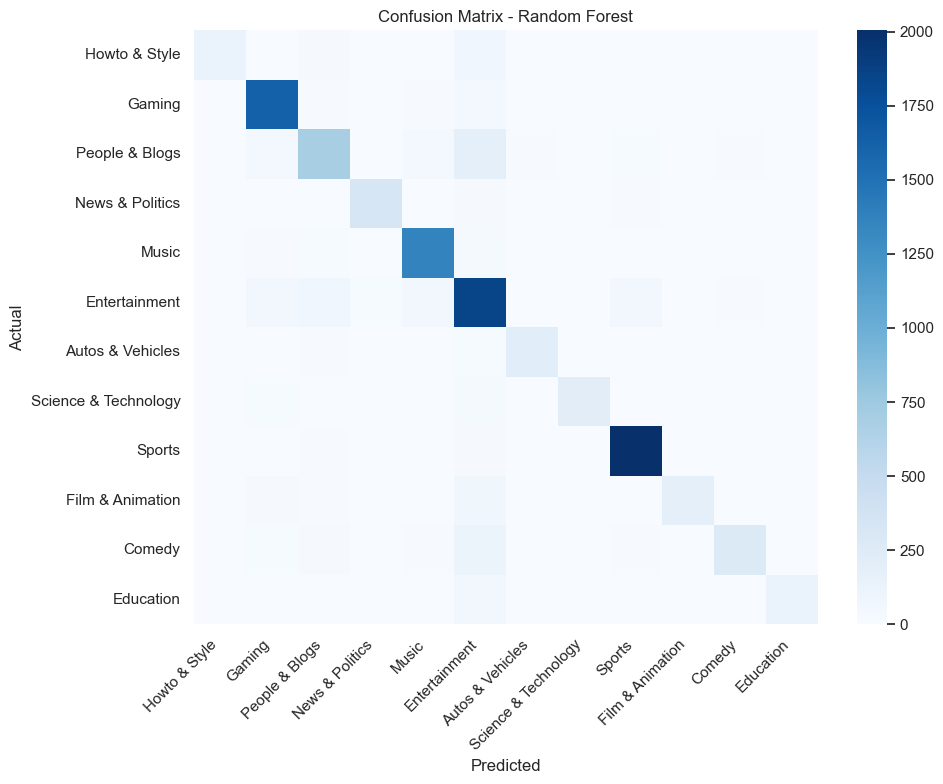

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt            
import seaborn as sns   


%matplotlib inline
sns.set(style="whitegrid")


# Combining cleaned text fields into a single feature for modeling
df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_tags'] + ' ' + df['cleaned_description']


X = df['combined_text']   
y = df['category_name'] 


# stratify=y maintains the same proportion of classes in both training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=10, stratify=y
)


print(f'Training set: {X_train.shape[0]} records')
print(f'Test set: {X_test.shape[0]} records')


# Initializing the TfidfVectorizer for converting text data into numerical features
vectorizer = TfidfVectorizer()

# Fitting the vectorizer on the training data
X_train_v = vectorizer.fit_transform(X_train)

# Transforming the test data
X_test_v = vectorizer.transform(X_test)

# Printing the shape of the vectorized training and testing data
print(f'Training set after vectorization: {X_train_v.shape}')
print(f'Test set after vectorization: {X_test_v.shape}')

# Initializing the Random Forest Classifier with specified parameters
rf_model = RandomForestClassifier(
    n_estimators=500,    # Number of trees in the forest
    random_state=10,     # Ensures reproducibility of the results
    n_jobs=-1            # Utilize all available CPU cores for parallel processing (to run fast, I was tired of waiting)
)

rf_model.fit(X_train_v, y_train)
y_pred_rf = rf_model.predict(X_test_v)

def evaluate_model(y_true, y_pred):
    
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    plt.figure(figsize=(10, 8)) 
    cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                     xticklabels=y_true.unique(), 
                     yticklabels=y_true.unique())
    
    plt.title(f'Confusion Matrix - Random Forest')  
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    plt.xticks(rotation=45)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')
        label.set_verticalalignment('top')

    
    plt.tight_layout()
    # plt.savefig("cm.png", transparent=True)
    plt.show()

# Evaluating the Random Forest model
evaluate_model(y_test, y_pred_rf)


In [7]:
import joblib
# Save the Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')
print("Random Forest model saved as 'random_forest_model.pkl'.")

# Save the TF-IDF Vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')
print("Vectorizer saved as 'vectorizer.pkl'.")

Random Forest model saved as 'random_forest_model.pkl'.
Vectorizer saved as 'vectorizer.pkl'.


## CUSTOM TEST FOR A SINGLE VIDEO (manually written title, tags etc)

In [8]:
def predictCateg(cTitle, cTags, cDesc):
    custom_text = f"{cTags.replace('|', ' ')} {clean_text(cTitle)} {clean_text(cDesc)}"
    custom_text_vectorized = vectorizer.transform([custom_text])
    answer = rf_model.predict(custom_text_vectorized)[0]
    print("I think the category is : " + answer )

In [9]:
custom_title = "Funny cats compilation"
custom_tags = "animals|cats|kitties|funny|compilation"
custom_description = "watch funny cats HD high quality video mega compilation. Funny animals"

predictCateg(custom_title, custom_tags, custom_description)

I think the category is : Entertainment


In [10]:
custom_title = "Minecraft let's play"
custom_tags = "minecraft"
custom_channelTitle = "Gamer44444"
custom_description = "In this episode we'll search for diamonds"

predictCateg(custom_title, custom_tags, custom_description)

I think the category is : Gaming


In [11]:
custom_title = "First space shuttle"
custom_tags = "space|science|NASA"
custom_channelTitle = "NASA"
custom_description = "First space shuttle history"

predictCateg(custom_title, custom_tags, custom_description)

I think the category is : Science & Technology


In [12]:
custom_title = "Official music video"
custom_tags = "new song|guitar"
custom_channelTitle = ""
custom_description = "Vocals by: e composed by: e"

predictCateg(custom_title, custom_tags, custom_description)

I think the category is : Music


In [13]:
custom_title = "Police ram straight through climate activist blockade in Nevada"
custom_tags = ""
custom_channelTitle = "The Telegraph"
custom_description = "Frightened activists screamed as the truck drove straight through the blockade, damaging the setup and the truck itself."

predictCateg(custom_title, custom_tags, custom_description)

I think the category is : News & Politics
